# EE5183 Financial Technology - GNN Workshop

## Setup

In [6]:
# Install required packages.
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

def format_pytorch_version(version):
	return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
	return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install pyg-lib -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html

!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
2.6.0


AttributeError: 'NoneType' object has no attribute 'replace'

In [ ]:
# ----- Standard Libraries -----
from typing import Optional, Tuple, Dict

# ----- Third-party Packages -----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
from tqdm import tqdm

# ----- PyTorch -----
import torch
import torch.nn.functional as F

# ----- PyTorch Geometric -----
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import Data

## Helper Functions for Visualisation

In [ ]:
# Helper function for visualization.
def visualize_graph(G: nx.Graph, color: torch.Tensor) -> None:
	"""
	Visualizes a graph using NetworkX and Matplotlib.

	Args:
		G (nx.Graph): The graph to visualize.
		color (torch.Tensor): A tensor containing node colors.

	Returns:
		None
	"""
	plt.figure(figsize=(7, 7))
	plt.xticks([])
	plt.yticks([])
	nx.draw_networkx(
		G, pos=nx.spring_layout(G, seed=42), with_labels=False,
		node_color=color, cmap="Set2")
	plt.show()


def visualize_embedding(
		h: torch.Tensor,
		color: torch.Tensor,
		epoch: Optional[int] = None,
		loss: Optional[torch.Tensor] = None) -> None:
	"""
	Visualizes embeddings in a 2D space using Matplotlib.

	Args:
		h (torch.Tensor): The embedding tensor of shape (num_nodes, 2).
		color (torch.Tensor): A tensor containing node colors.
		epoch (Optional[int]): The current epoch number (default: None).
		loss (Optional[torch.Tensor]): The loss value (default: None).

	Returns:
		None
	"""
	plt.figure(figsize=(7, 7))
	plt.xticks([])
	plt.yticks([])
	h = h.detach().cpu().numpy()
	plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
	if epoch is not None and loss is not None:
		plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
	plt.show()

## Section 1 - Core Concepts of PyTorch Geometric

### 1. Data Representation

We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

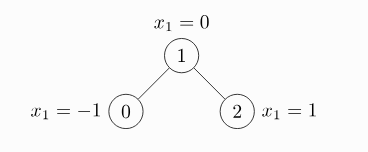

In [ ]:
# Define an edge list
edge_index = torch.tensor([
	[0, 1, 1 ,2],   # source nodes
	[1, 0, 2, 1]], # target nodes
	dtype=torch.long)

# Define node features (e.g., node labels or embeddings)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# Create a Data object
data = Data(x=x, edge_index=edge_index)
print(data)

### 2. Datasets in PyG

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

PyTorch Geometric provides an easy access to this dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [ ]:
from torch_geometric.datasets import KarateClub

# Load the dataset
dataset = KarateClub()

# Inspect the dataset
print(f"Dataset: {dataset}")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Node features: {dataset[0].num_node_features}")
print(f"Classes: {dataset.num_classes}")

After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) **node labels** as `y` (each node is assigned to exactly one class).
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

Let us now inspect the `edge_index` property in more detail:

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

#### **Activity 1:** Try another dataset (except Cora) and report the statistics.

### 3. Implementing Graph Neural Networks

#### 3.1 Dataset

Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(
	root='./data/Planetoid',
	name='Cora',
	transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

#### Bulding a Graph Neural Network

Let's start with something simple yet effective: a Graph Convolutional Network (GCN). To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
	"""
	A Graph Convolutional Network (GCN) implementation using PyTorch Geometric.

	Attributes:
		conv1 (GCNConv): The first graph convolutional layer.
		conv2 (GCNConv): The second graph convolutional layer.

	Methods:
		forward(x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
			Defines the forward pass of the GCN model.
	"""
	# TODO: Modify the architecture to achieve a better result.
	def __init__(
			self,
			input_channels: int,
			hidden_channels: int,
			output_channels: int) -> None:
		"""
		Initializes the GCN model.

		Args:
			input_channels (int): Number of input features per node.
			hidden_channels (int): Number of hidden units in the first layer.
			output_channels (int): Number of output features per node.
		"""
		super().__init__()
		torch.manual_seed(1234567)
		self.conv1 = GCNConv(input_channels, hidden_channels)
		self.conv2 = GCNConv(hidden_channels, output_channels)

	def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
		"""
		Defines the forward pass of the GCN model.

		Args:
			x (torch.Tensor): Node feature matrix of shape [num_nodes, num_features].
			edge_index (torch.Tensor): Graph connectivity in COO format with shape [2, num_edges].

		Returns:
			torch.Tensor: Output node embeddings of shape [num_nodes, output_channels].
		"""
		x = self.conv1(x, edge_index)
		x = x.relu()
		x = F.dropout(x, p=0.5, training=self.training)
		x = self.conv2(x, edge_index)
		return x

model = GCN(
	input_channels=dataset.num_features,
	hidden_channels=16,
	output_channels=dataset.num_classes)
print(model)

#### Training Loop

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# ----- Initialisation ----- #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

# TODO: Change the hyperparameters to see if the accuracy increases
model = GCN(
	input_channels=dataset.num_features,
	hidden_channels=16,
	output_channels=dataset.num_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
data = data.to(device)  # Move data to the same device as the model.


# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# ----- Training Function ----- #
def train() -> Tuple[torch.Tensor, float]:
	"""
	Trains the model for one epoch.

	Returns:
		Tuple[torch.Tensor, float]: The training loss and accuracy.
	"""
	model.train()
	optimizer.zero_grad()  # Clear gradients.
	out = model(data.x, data.edge_index)  # Perform a single forward pass.
	loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
	loss.backward()  # Derive gradients.
	optimizer.step()  # Update parameters based on gradients.
	acc = test(data.train_mask)  # Compute training accuracy.
	return loss, acc

# ----- Validation Function ----- #
def validate() -> Tuple[torch.Tensor, float]:
	"""
	Validates the model.

	Returns:
		Tuple[torch.Tensor, float]: The validation loss and accuracy.
	"""
	model.eval()
	with torch.no_grad():
		out = model(data.x, data.edge_index)
		val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute validation loss.
		acc = test(data.val_mask)  # Compute validation accuracy.
	return val_loss, acc

# ----- Testing Function ----- #
def test(mask: torch.Tensor) -> float:
	"""
	Tests the model on a given mask.

	Args:
		mask (torch.Tensor): A boolean mask indicating the nodes to test on.

	Returns:
		float: The accuracy of the model on the given mask.
	"""
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)  # Use the class with highest probability.
	correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
	acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
	return acc

# ----- Training Loop ----- #
for epoch in range(1, 101):
	train_loss, train_acc = train()
	val_loss, val_acc = validate()
	train_losses.append(train_loss.item())
	val_losses.append(val_loss.item())
	train_accuracies.append(train_acc)
	val_accuracies.append(val_acc)
	print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# ----- Visualising the Training Process ----- #
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 101), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

After training the model, we can check its test accuracy:

In [ ]:
# ----- Evaluation on the Test Set ----- #
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

#### **Activity 2:** Try to achieve a higher test accuracy for the GCN and report the result.

#### **Activity 3:** Change to GAT and report the test accuracy

Try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
	def __init__(self, hidden_channels, heads):
		super().__init__()
		torch.manual_seed(1234567)
		self.conv1 = GATConv(...)  # TODO
		self.conv2 = GATConv(...)  # TODO

	def forward(self, x, edge_index):
		x = F.dropout(x, p=0.6, training=self.training)
		x = self.conv1(x, edge_index)
		x = F.elu(x)
		x = F.dropout(x, p=0.6, training=self.training)
		x = self.conv2(x, edge_index)
		return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
	model.train()
	optimizer.zero_grad()  # Clear gradients.
	out = model(data.x, data.edge_index)  # Perform a single forward pass.
	loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
	loss.backward()  # Derive gradients.
	optimizer.step()  # Update parameters based on gradients.
	return loss

def test(mask):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)  # Use the class with highest probability.
	correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
	acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
	return acc


for epoch in range(1, 201):
	loss = train()
	val_acc = test(data.val_mask)
	test_acc = test(data.test_mask)
	print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

## Section 2: From Homogeneous to Heterogeneous GNNs

### 1. Dataset: DBLP

In [ ]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import torch

from torch_geometric.data import (
    HeteroData,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [ ]:
# ----- Define the Dataset Class ----- #
class DBLP(InMemoryDataset):
    r"""A subset of the DBLP computer science bibliography website, as
    collected in the `"MAGNN: Metapath Aggregated Graph Neural Network for
    Heterogeneous Graph Embedding" <https://arxiv.org/abs/2002.01680>`_ paper.
    DBLP is a heterogeneous graph containing four types of entities - authors
    (4,057 nodes), papers (14,328 nodes), terms (7,723 nodes), and conferences
    (20 nodes).
    The authors are divided into four research areas (database, data mining,
    artificial intelligence, information retrieval).
    Each author is described by a bag-of-words representation of their paper
    keywords.

    Args:
        root (str): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)
    """

    url = 'https://www.dropbox.com/s/yh4grpeks87ugr2/DBLP_processed.zip?dl=1'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        super().__init__(root, transform, pre_transform,
                         force_reload=force_reload)
        self.load(self.processed_paths[0], data_cls=HeteroData)

    @property
    def raw_file_names(self) -> List[str]:
        return [
            'adjM.npz', 'features_0.npz', 'features_1.npz', 'features_2.npy',
            'labels.npy', 'node_types.npy', 'train_val_test_idx.npz'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self) -> None:
        import scipy.sparse as sp

        data = HeteroData()

        node_types = ['author', 'paper', 'term', 'conference']
        for i, node_type in enumerate(node_types[:2]):
            x = sp.load_npz(osp.join(self.raw_dir, f'features_{i}.npz'))
            data[node_type].x = torch.from_numpy(x.todense()).to(torch.float)

        x = np.load(osp.join(self.raw_dir, 'features_2.npy'))
        data['term'].x = torch.from_numpy(x).to(torch.float)

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)
        data['conference'].num_nodes = int((node_type_idx == 3).sum())

        y = np.load(osp.join(self.raw_dir, 'labels.npy'))
        data['author'].y = torch.from_numpy(y).to(torch.long)

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['author'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['author'][f'{name}_mask'] = mask

        s = {}
        N_a = data['author'].num_nodes
        N_p = data['paper'].num_nodes
        N_t = data['term'].num_nodes
        N_c = data['conference'].num_nodes
        s['author'] = (0, N_a)
        s['paper'] = (N_a, N_a + N_p)
        s['term'] = (N_a + N_p, N_a + N_p + N_t)
        s['conference'] = (N_a + N_p + N_t, N_a + N_p + N_t + N_c)

        A = sp.load_npz(osp.join(self.raw_dir, 'adjM.npz'))
        for src, dst in product(node_types, node_types):
            A_sub = A[s[src][0]:s[src][1], s[dst][0]:s[dst][1]].tocoo()
            if A_sub.nnz > 0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data[src, dst].edge_index = torch.stack([row, col], dim=0)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        self.save([data], self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [ ]:
# ----- Download and Process the Dataset ----- #
path = "./data/dblp"
os.makedirs(path, exist_ok=True)

# Download dataset
dataset = DBLP(
    root=path,
    transform=T.Compose([
        T.Constant(node_types="conference")]),
    force_reload=True)
data = dataset[0]
print(data)

In [ ]:
# ----- Graph Statistics ----- #
# Single node/edge data
print(data["paper"], "\n", data["paper", "to", "author"])

# Access the meta-data
node_types, edge_types = data.metadata()
print(node_types, "\n",  edge_types)

# Additional helper analysis functions
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

In [ ]:
print(f"Training nodes: {data['author'].train_mask.sum()}")
print(f"Validation nodes: {data['author'].val_mask.sum()}")
print(f"Test nodes: {data['author'].test_mask.sum()}")
print(f"Unique labels: {data['author'].y.unique()}")
num_classes = len(data["author"].y.unique())
print(f"Number of classes: {num_classes}")

In [ ]:
# ----- Convert to a homogeneous graph ----- #
homogeneous_data = data.to_homogeneous()
print(homogeneous_data)

### 2. Heterogeneous Graph Samplers

PyG provides various functionalities for sampling heterogenenous graphs, i.e., in the standard `torch_geometric.loader.NeighborLoader` class or in dedicated heterogeneous graph samplers such as `torch_geometric.loader.HGTLoader`. This is especially useful for efficient representation learning on larger heterogeneous graphs, where processing the full number of neighbours is too computationally expensive.

Overall, all heterogeneous graph loaders will prodcue a `HeteroData` object as output, holding a subset of the original data, and mainly differ in the way their sampling procedures works. As such, only minimal code changes are required to convert the training procedure from full-batch training to mini-batch training.

In [ ]:
# ----- Graph Neighbour Sampling ----- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Send node features/labels to GPU for faster access during sampling
data = data.to(device, "x", "y")

# Extract the training/validation/test nodes
train_input_nodes = ("author", data["author"].train_mask)
val_input_nodes = ("author", data["author"].val_mask)
test_input_nodes = ("author", data["author"].test_mask)

kwargs = {'batch_size': 1024, 'num_workers': 2, 'persistent_workers': True}

# DataLoader.
# TODO: Small graph, change the number of neighbours
train_loader = torch_geometric.loader.NeighborLoader(
    data=data,
    # Sample 15 neighbours for each node and each edge type for 5 iterations
    num_neighbors=[15] * 5,
    shuffle=True,
    input_nodes=train_input_nodes,
    **kwargs)
val_loader = torch_geometric.loader.NeighborLoader(
    data=data,
    num_neighbors=[15] * 5,
    shuffle=False,
    input_nodes=val_input_nodes,
    **kwargs)
test_loader = torch_geometric.loader.NeighborLoader(
    data=data,
    num_neighbors=[15] * 5,
    shuffle=False,
    input_nodes=test_input_nodes,
    **kwargs)

In [ ]:
batch = next(iter(train_loader))
print(batch)

### 3. Creating Heterogeneous GNNs

Standard Message Passing GNNs (MP-GNNs) cannot trivially be applied to heterogeneous graph data, as node and edge features from different types cannot be processed by the same functions due to differences in feature type. A natural way to circumvent this is to implement message and update functions individually for each eage type. During runtime, the MP-GNN algorithm would need to iterate over edge type dictionaries during node updates.

#### 3.1 Automatically Converting GNN Models

In [ ]:
# ----- GAT with Skip-connections ----- #
from torch_geometric.nn import GATConv, Linear, to_hetero

class GAT(torch.nn.Module):
	"""
	A Graph Attention Network (GAT) implementation with skip-connections.

	Attributes:
		conv1 (GATConv): The first graph attention layer.
		lin1 (Linear): Linear layer for skip-connection in the first layer.
		conv2 (GATConv): The second graph attention layer.
		lin2 (Linear): Linear layer for skip-connection in the second layer.

	Methods:
		forward(x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
			Defines the forward pass of the GAT model.
	"""
	# TODO: Modify the architecture to achieve a better result
	def __init__(self, hidden_channels: int, out_channels: int) -> None:
		"""
		Initializes the GAT model.

		Args:
			hidden_channels (int): Number of hidden units in the first layer.
			out_channels (int): Number of output features per node.
		"""
		super().__init__()
		self.conv1 = GATConv(
			in_channels=(-1, -1),
			out_channels=hidden_channels,
			heads=1,  # default value
			add_self_loops=False)
		self.lin1 = Linear(
			in_channels=-1,
			out_channels=hidden_channels)
		self.conv2 = GATConv(
			in_channels=(-1, -1),
			out_channels=out_channels,
			heads=1,  # default value
			add_self_loops=False)
		self.lin2 = Linear(
			in_channels=-1,
			out_channels=out_channels)

	def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
		"""
		Defines the forward pass of the GAT model.

		Args:
			x (torch.Tensor): Node feature matrix of shape [num_nodes, num_features].
			edge_index (torch.Tensor): Graph connectivity in COO format with shape [2, num_edges].

		Returns:
			torch.Tensor: Output node embeddings of shape [num_nodes, out_channels].
		"""
		x = self.conv1(x, edge_index) + self.lin1(x)
		x = x.relu()
		x = self.conv2(x, edge_index) + self.lin2(x)
		return x

In [ ]:
# ----- Initialisation ----- #
# num_classes = len(data["author"].y.unique())
# print(f"Number of classes: {num_classes}")

gat_model = GAT(hidden_channels=64, out_channels=num_classes)
gat_model = to_hetero(gat_model, data.metadata(), aggr="sum")
# print(gat_model)

The process takes an existing GNN model and duplicates the message passing fuctions to work on each edge type individually.

As the result, the model now expects dictionaries with node and edge types as keys as input arguments, rather than single tensors utilised in homogeneous graphs.

<b><u>Note</u>:</b> Since the number of input features and thus the size of tensors varies between different types, PyG can make use of **lazy intialisation** to initialise parameters in heterogeneous GNNs (as denoted by `-1` as the `in_channels` argument). This allows us to avoide calculating and keeping track of all tensor sizes of the computation graph. Lazy intialisation is supoported for all existing PyG operators.

In [ ]:
# ----- Training Function ----- #
def train(
		model: torch.nn.Module,
		loader: torch_geometric.loader.NeighborLoader,
		optimizer: torch.optim.Optimizer,
		device: torch.device) -> float:
	"""
	Trains the model for one epoch.

	Args:
		model (torch.nn.Module): The model to train.
		loader (torch_geometric.loader.NeighborLoader): The data loader for training batches.
		optimizer (torch.optim.Optimizer): The optimizer used for training.
		device (torch.device): The device to run the training on (e.g., 'cuda' or 'cpu').

	Returns:
		float: The average training loss for the epoch.
	"""
	model.train()

	total_examples = total_loss = 0

	for batch in tqdm(loader):
		optimizer.zero_grad()
		batch = batch.to(device, "edge_index")
		batch_size = batch["author"].batch_size
		# Pay attention to the output of the model
		out = model(batch.x_dict, batch.edge_index_dict)["author"][:batch_size]
		loss = F.cross_entropy(out, batch["author"].y[:batch_size])
		loss.backward()
		optimizer.step()

		total_examples += batch_size
		total_loss += float(loss) * batch_size

	return total_loss / total_examples

# ----- Evaluation Function ----- #
@torch.no_grad()
def test(
	model: torch.nn.Module,
	loader: torch_geometric.loader.NeighborLoader,
	device: torch.device) -> float:
	"""
	Evaluates the model on a given dataset.

	Args:
		model (torch.nn.Module): The model to evaluate.
		loader (torch_geometric.loader.NeighborLoader): The data loader for evaluation batches.
		device (torch.device): The device to run the evaluation on (e.g., 'cuda' or 'cpu').

	Returns:
		float: The accuracy of the model on the evaluation dataset.
	"""
	model.eval()

	total_examples = total_correct = 0

	for batch in tqdm(loader):
		batch = batch.to(device, "edge_index")
		batch_size = batch["author"].batch_size
		out = model(batch.x_dict, batch.edge_index_dict)["author"][:batch_size]
		pred = out.argmax(dim=-1)

		total_examples += batch_size
		total_correct += int((pred == batch["author"].y[:batch_size]).sum())

	return total_correct / total_examples

# ----- Function to Initialise Parameters ----- #
@torch.no_grad()
def init_params(
	model: torch.nn.Module,
	loader: torch_geometric.loader.NeighborLoader,
	device: torch.device) -> None:
	"""
	Initialises lazy parameters by forwarding a single batch to the model.

	Args:
		model (torch.nn.Module): The model to initialise.
		loader (torch_geometric.loader.NeighborLoader): The data loader for a single batch.
		device (torch.device): The device to run the initialisation on (e.g., 'cuda' or 'cpu').
	"""
	batch = next(iter(loader))
	batch = batch.to(device, "edge_index")
	model(batch.x_dict, batch.edge_index_dict)

# ----- Initialisation ----- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gat_model = gat_model.to(device)

init_params(model=gat_model, loader=train_loader, device=device)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01) #TODO: adjust LR

# Print the test accuracy before training
print(f"Test: {test(gat_model, test_loader, device): 0.4f} \n")

# ----- Training Loop ----- #
for epoch in range(1, 51):
    loss = train(gat_model, train_loader, optimizer, device)
    val_acc = test(gat_model, val_loader, device)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")

print(f"\n Test: {test(gat_model, test_loader, device): 0.4f} \n")

#### 3.2 Using the Heterogeneous Convolution Wrapper

The heterogeneous convolution wrapper `torch_geometric.nn.conv.HeteroConv` allows to define custom heterogeneous message and update functions to build arbitrary MP-GNNs for heterogeneous graphs from scratch. While the automatic converter `to_hetero()` uses the same operator for all edge types, the wrapper allows to define different operators for different edge types. Here, `HeteroConv` takes a dictionary of submodules as input, one for each edge type in the graph data.

In [ ]:
from torch_geometric.nn import HeteroConv, SAGEConv, GATConv, Linear

class HeteroGNN(torch.nn.Module):
	"""
	A Heterogeneous Graph Neural Network (HeteroGNN) implementation using PyTorch Geometric.

	Attributes:
		convs (torch.nn.ModuleList): A list of HeteroConv layers for message passing.
		lin (torch.nn.Linear): A linear layer for final node classification.

	Methods:
		forward(x_dict: Dict[str, torch.Tensor], edge_index_dict: Dict[Tuple[str, str, str], torch.Tensor]) -> torch.Tensor:
			Defines the forward pass of the HeteroGNN model.
	"""
	def __init__(
			self,
			hidden_channels: int,
			out_channels: int,
			num_layers: int) -> None:
		"""
		Initializes the HeteroGNN model.

		Args:
			hidden_channels (int): Number of hidden units in each layer.
			out_channels (int): Number of output features per node.
			num_layers (int): Number of HeteroConv layers in the model.
		"""
		super().__init__()

		self.convs = torch.nn.ModuleList()

		for _ in range(num_layers):
			conv = HeteroConv({
				('author', 'to', 'paper'): SAGEConv(
					in_channels=(-1, -1),
					out_channels=hidden_channels),
				('paper', 'to', 'term'): SAGEConv(
					in_channels=(-1, -1),
					out_channels=hidden_channels),
				('paper', 'to', 'conference'): SAGEConv(
					in_channels=(-1, -1),
					out_channels=hidden_channels),
				('paper', 'to', 'author'): GATConv(
					in_channels=(-1, -1),
					out_channels=hidden_channels,
					add_self_loops=False),
				('paper', 'to', 'term'): GATConv(
					in_channels=(-1, -1),
					out_channels=hidden_channels,
					add_self_loops=False),
				('paper', 'to', 'conference'): GATConv(
					in_channels=(-1, -1),
					out_channels=hidden_channels,
					add_self_loops=False),
			}, aggr='sum')
			self.convs.append(conv)

		self.lin = Linear(
			in_channels=hidden_channels,
			out_channels=out_channels)

	def forward(
			self,
			x_dict: Dict[str, torch.Tensor],
			edge_index_dict: Dict[Tuple[str, str, str], torch.Tensor]) -> torch.Tensor:
		"""
		Defines the forward pass of the HeteroGNN model.

		Args:
			x_dict (Dict[str, torch.Tensor]): A dictionary containing node feature matrices for each node type.
			edge_index_dict (Dict[Tuple[str, str, str], torch.Tensor]): A dictionary containing edge indices for each edge type.

		Returns:
			torch.Tensor: Output node embeddings for the 'author' node type.
		"""
		for conv in self.convs:
			x_dict = conv(x_dict, edge_index_dict)
			x_dict = {key: x.relu() for key, x in x_dict.items()}

		return self.lin(x_dict['author'])

wrapper_model = HeteroGNN(
    hidden_channels=64,
    out_channels=num_classes,
    num_layers=3)

In [ ]:
# ----- Training Function ----- #
def train(
		model: torch.nn.Module,
		loader: torch_geometric.loader.NeighborLoader,
		optimizer: torch.optim.Optimizer,
		device: torch.device) -> float:
	"""
	Trains the model for one epoch.

	Args:
		model (torch.nn.Module): The model to train.
		loader (torch_geometric.loader.NeighborLoader): The data loader for training batches.
		optimizer (torch.optim.Optimizer): The optimizer used for training.
		device (torch.device): The device to run the training on (e.g., 'cuda' or 'cpu').

	Returns:
		float: The average training loss for the epoch.
	"""
	model.train()

	total_examples = total_loss = 0

	for batch in tqdm(loader):
		optimizer.zero_grad()
		batch = batch.to(device, "edge_index")
		batch_size = batch["author"].batch_size
		# Note: Output different from the previous one
		out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
		loss = F.cross_entropy(out, batch["author"].y[:batch_size])
		loss.backward()
		optimizer.step()

		total_examples += batch_size
		total_loss += float(loss) * batch_size

	return total_loss / total_examples

# ----- Evaluation Function ----- #
@torch.no_grad()
def test(model: torch.nn.Module, loader: torch_geometric.loader.NeighborLoader, device: torch.device) -> float:
	"""
	Evaluates the model on a given dataset.

	Args:
		model (torch.nn.Module): The model to evaluate.
		loader (torch_geometric.loader.NeighborLoader): The data loader for evaluation batches.
		device (torch.device): The device to run the evaluation on (e.g., 'cuda' or 'cpu').

	Returns:
		float: The accuracy of the model on the evaluation dataset.
	"""
	model.eval()

	total_examples = total_correct = 0

	for batch in tqdm(loader):
		batch = batch.to(device, "edge_index")
		batch_size = batch["author"].y.size(0)
		# The output of the model is directly used
		out = model(batch.x_dict, batch.edge_index_dict)
		pred = out.argmax(dim=-1)

		total_examples += batch_size
		total_correct += int((pred == batch["author"].y[:batch_size]).sum())

	return total_correct / total_examples

# ----- Initialisation ----- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapper_model = wrapper_model.to(device)

init_params(model=wrapper_model, loader=train_loader, device=device)
optimizer = torch.optim.Adam(wrapper_model.parameters(), lr=0.01)
print(f"Test: {test(wrapper_model, test_loader, device): 0.4f} \n")

# ----- Training Loop ----- #
for epoch in range(1, 51):
    loss = train(wrapper_model, train_loader, optimizer, device)
    val_acc = test(wrapper_model, val_loader, device)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")

print(f"\n Test: {test(wrapper_model, test_loader, device): 0.4f} \n")

#### 3.3 Deploying Existing Heterogeneous Operators

PyG provides operators (e.g., `torch_geometric.nn.conv.HGTConv`), which are specifically desgined for heterogeneous graphs. These operators can be directly used to build heterogeneous GNN models.

In [ ]:
from torch_geometric.nn import HGTConv

class HGT(torch.nn.Module):
	"""
	A Heterogeneous Graph Transformer (HGT) implementation using PyTorch Geometric.

	Attributes:
		lin_dict (torch.nn.ModuleDict): A dictionary of linear layers for each node type.
		convs (torch.nn.ModuleList): A list of HGTConv layers for message passing.
		lin (torch.nn.Linear): A linear layer for final node classification.

	Methods:
		forward(x_dict: Dict[str, torch.Tensor], edge_index_dict: Dict[Tuple[str, str, str], torch.Tensor]) -> torch.Tensor:
			Defines the forward pass of the HGT model.
	"""
	def __init__(
			self,
			hidden_channels: int,
			out_channels: int,
			num_heads: int,
			num_layers: int) -> None:
		"""
		Initializes the HGT model.

		Args:
			hidden_channels (int): Number of hidden units in each layer.
			out_channels (int): Number of output features per node.
			num_heads (int): Number of attention heads in each HGTConv layer.
			num_layers (int): Number of HGTConv layers in the model.
		"""
		super().__init__()

		self.lin_dict = torch.nn.ModuleDict()
		for node_type in data.node_types:
			self.lin_dict[node_type] = Linear(
				in_channels=-1,
				out_channels=hidden_channels)

		self.convs = torch.nn.ModuleList()
		for _ in range(num_layers):
			conv = HGTConv(
				in_channels=hidden_channels,
				out_channels=hidden_channels,
				metadata=data.metadata(),
				heads=num_heads)
			self.convs.append(conv)

		self.lin = Linear(
			in_channels=hidden_channels,
			out_channels=out_channels)

	def forward(
			self,
			x_dict: Dict[str, torch.Tensor],
			edge_index_dict: Dict[Tuple[str, str, str], torch.Tensor]) -> torch.Tensor:
		"""
		Defines the forward pass of the HGT model.

		Args:
			x_dict (Dict[str, torch.Tensor]): A dictionary containing node feature matrices for each node type.
			edge_index_dict (Dict[Tuple[str, str, str], torch.Tensor]): A dictionary containing edge indices for each edge type.

		Returns:
			torch.Tensor: Output node embeddings for the 'author' node type.
		"""
		for node_type, x in x_dict.items():
			x_dict[node_type] = self.lin_dict[node_type](x).relu_()

		for conv in self.convs:
			x_dict = conv(x_dict, edge_index_dict)

		return self.lin(x_dict['author'])

hgt_model = HGT(
    hidden_channels=64,
    out_channels=num_classes,
    num_heads=2,
    num_layers=2)

In [ ]:
# ----- Initialisation ----- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hgt_model = hgt_model.to(device)

init_params(model=hgt_model, loader=train_loader, device=device)
optimizer = torch.optim.Adam(hgt_model.parameters(), lr=0.01)
print(f"Test: {test(hgt_model, test_loader, device): 0.4f} \n")

# ----- Training Loop ----- #
for epoch in range(1, 51):
    loss = train(hgt_model, train_loader, optimizer, device)
    val_acc = test(hgt_model, val_loader, device)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}")

print(f"\n Test: {test(hgt_model, test_loader, device): 0.4f} \n")